In [1]:
%matplotlib inline

In [2]:
import numpy as np

### Data Loading 

In [3]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "data/HAR_pose_activities/database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [4]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

### Pre-Process 

In [5]:
import torch

In [6]:
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([5751, 32, 36])
test_label_size: torch.Size([5751, 1])
n_data_size_test: 5751
train_data_size: torch.Size([22625, 32, 36])
train_label_size: torch.Size([22625, 1])
n_data_size_train: 22625


In [7]:
import torch.nn as nn

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(32)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [10]:
n_hidden = 128
n_joints = 18*2
n_categories = 6
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(36, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

### Getting Random Data 

In [12]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Training

In [13]:
#try:
#    rnn.load_state_dict(torch.load('lstm_6.pkl'))
#except:
#    print('no pkl')

In [14]:
import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 100000
#n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 5s) 1.5257  / WAVING_1HAND ✓
2000 2% (0m 10s) 1.7225  / WAVING_1HAND ✗ (BOXING)
3000 3% (0m 16s) 1.5120  / WAVING_1HAND ✗ (BOXING)
4000 4% (0m 21s) 1.6010  / WAVING_2HANDS ✗ (BOXING)
5000 5% (0m 26s) 1.5439  / WAVING_1HAND ✗ (BOXING)
6000 6% (0m 32s) 1.8680  / WAVING_1HAND ✗ (JUMPING_JACKS)
7000 7% (0m 37s) 2.3380  / BOXING ✗ (CLAPPING_HANDS)
8000 8% (0m 42s) 1.4962  / WAVING_1HAND ✗ (WAVING_2HANDS)
9000 9% (0m 47s) 1.4200  / BOXING ✓
10000 10% (0m 52s) 2.1142  / WAVING_1HAND ✗ (JUMPING)
11000 11% (0m 58s) 0.1946  / WAVING_1HAND ✓
12000 12% (1m 3s) 0.1302  / WAVING_1HAND ✓
13000 13% (1m 8s) 0.0849  / WAVING_1HAND ✓
14000 14% (1m 13s) 0.9890  / WAVING_2HANDS ✓
15000 15% (1m 18s) 0.0783  / WAVING_1HAND ✓
16000 16% (1m 24s) 0.3485  / WAVING_1HAND ✓
17000 17% (1m 29s) 0.3475  / JUMPING ✓
18000 18% (1m 33s) 0.5152  / CLAPPING_HANDS ✗ (BOXING)
19000 19% (1m 38s) 0.5965  / WAVING_2HANDS ✓
20000 20% (1m 44s) 1.0362  / BOXING ✗ (CLAPPING_HANDS)
21000 21% (1m 49s) 0.0054  / WAVING_1H

In [15]:
torch.save(rnn.state_dict(),'lstm_6_bn.pkl')

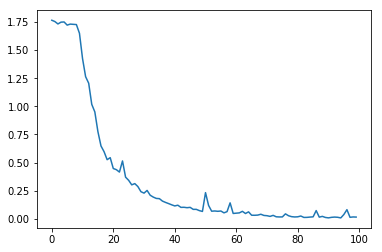

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing

In [17]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print(flag,'accuracy',right/n)

In [18]:
test('test')

test accuracy 0.967831681446705


In [19]:
test('train')

train accuracy 0.9888618784530386


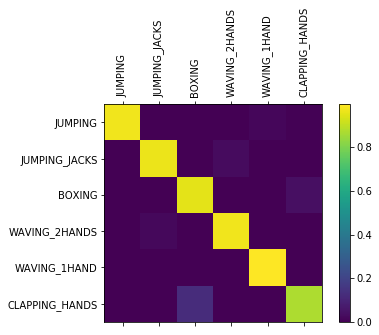

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()